In [1]:
# -*- coding: utf-8 -*-
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.visualization import timeline_drawer
from qiskit.visualization.timeline import draw, IQXSimple, IQXStandard

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Import measurement calibration functions
from qiskit.ignis.mitigation import MeasurementFilter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

# For data fitting
from lmfit import Model

C:\Users\usuario\AppData\Local\Temp\ipykernel_14992\2715227163.py:18: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation import MeasurementFilter


In [2]:
provider = IBMQ.enable_account('account-id-here')
#provider = IBMQ.load_account()

In [3]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [4]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]
tau_cnot31 = CNOT_durations["[3, 1]"]

## Calibration
See https://github.com/Qiskit/qiskit-ignis#creating-your-first-quantum-experiment-with-qiskit-ignis

Generate the measurement calibration circuits for running measurement error mitigation:

In [55]:
qr = QuantumRegister(5)
meas_cals, state_labels = complete_meas_cal(qubit_list=[3], qr=qr)
tr_meas_cals = transpile(meas_cals, backend=backend, scheduling_method='asap', optimization_level=0)

Send the calibration job:

In [56]:
job_manager = IBMQJobManager()
job = job_manager.run(tr_meas_cals, backend=backend, name='calibration-8192shots-q3', shots=8192)

In [58]:
job.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

Get the calibration results:

In [59]:
cal_results = job.results().combine_results()

# Make a calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

# Create a measurement filter from the calibration matrix
meas_filter = meas_fitter.filter

Print the calibration matrix:

In [ ]:
calMatrix = meas_fitter.cal_matrix
calMatrix

In [5]:
# M^{-1}_3
calMatrix = np.array([[0.98657227, 0.05004883],
                      [0.01342773, 0.94995117]])

For building a filter from a calibration matrix already stored:

In [6]:
stateLabels = ["00", "01"]

meas_filter = MeasurementFilter(calMatrix, stateLabels)
meas_filter.cal_matrix

array([[0.98657227, 0.05004883],
       [0.01342773, 0.94995117]])

## Define the circuit creation functions

XYXY sequence:

In [7]:
def get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=0, DD_wait=True):  
        
    tau_block = 2*(X_duration+Y_duration)
    tau_swap  = 2*tau_cnot34 + tau_cnot43   
    tau_wait  = num_blocks*tau_block
    tau_meas  = Measurement_duration               

    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Data gate
    tau_data = 0
    if state==1:
        tau_data = X_duration
        circuit.x(3)
    elif state=="+":
        tau_data = H_duration
        circuit.h(3)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(3)
        circuit.h(3)
    
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)   
    
    num_blocks_data = int(np.floor(tau_wait/tau_block))
    wait_duration = tau_wait*dt_in_s*1e6
    if DD_wait==True:   
        for i in range(num_blocks_data):
            circuit.x(4)
            circuit.y(4)
            circuit.x(4)
            circuit.y(4)
    elif DD_wait==False:
        for i in range(num_blocks_data):
            for j in range(6):
                circuit.id(4)
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)  
    
    # Inverse data gate
    if state==1:
        circuit.x(3)
    elif state=="+":
        circuit.h(3)
    elif state=="-":
        circuit.h(3)
        circuit.x(3)

    circuit.measure(3,0)
    
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    return tcircuit, wait_duration

XZXZ sequence:

In [8]:
def get_protocol_transpiled_circuit_XZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=0, DD_wait=True):  
        
    tau_block = 2*X_duration
    tau_swap  = 2*tau_cnot34 + tau_cnot43  
    tau_wait  = num_blocks*tau_block
    tau_meas  = Measurement_duration               

    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Data gate
    tau_data = 0
    if state==1:
        tau_data = X_duration
        circuit.x(3)
    elif state=="+":
        tau_data = H_duration
        circuit.h(3)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(3)
        circuit.h(3)
    
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)   
    
    num_blocks_data = int(np.floor(tau_wait/tau_block))
    wait_duration = tau_wait*dt_in_s*1e6
    if DD_wait==True:   
        for i in range(num_blocks_data):
            circuit.x(4)
            circuit.z(4)
            circuit.x(4)
            circuit.z(4)
    elif DD_wait==False:
        for i in range(num_blocks_data):
            for j in range(2):
                circuit.id(4)
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)  
    
    # Inverse data gate
    if state==1:
        circuit.x(3)
    elif state=="+":
        circuit.h(3)
    elif state=="-":
        circuit.h(3)
        circuit.x(3)

    circuit.measure(3,0)
    
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    return tcircuit, wait_duration

YZYZ sequence:

In [9]:
def get_protocol_transpiled_circuit_YZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=0, DD_wait=True):  
        
    tau_block = 2*Y_duration
    tau_swap  = 2*tau_cnot34 + tau_cnot43  
    tau_wait  = num_blocks*tau_block
    tau_meas  = Measurement_duration               

    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Data gate
    tau_data = 0
    if state==1:
        tau_data = X_duration
        circuit.x(3)
    elif state=="+":
        tau_data = H_duration
        circuit.h(3)
    elif state=="-":
        tau_data = X_duration + H_duration
        circuit.x(3)
        circuit.h(3)
    
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)   
    
    num_blocks_data = int(np.floor(tau_wait/tau_block))
    wait_duration = tau_wait*dt_in_s*1e6
    if DD_wait==True:   
        for i in range(num_blocks_data):
            circuit.y(4)
            circuit.z(4)
            circuit.y(4)
            circuit.z(4)
    elif DD_wait==False:
        for i in range(num_blocks_data):
            for j in range(4):
                circuit.id(4)
    
    circuit.cnot(3,4)   
    circuit.cnot(4,3)   
    circuit.cnot(3,4)  
    
    # Inverse data gate
    if state==1:
        circuit.x(3)
    elif state=="+":
        circuit.h(3)
    elif state=="-":
        circuit.h(3)
        circuit.x(3)

    circuit.measure(3,0)
    
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    return tcircuit, wait_duration

**Check that the functions build the circuits correctly**

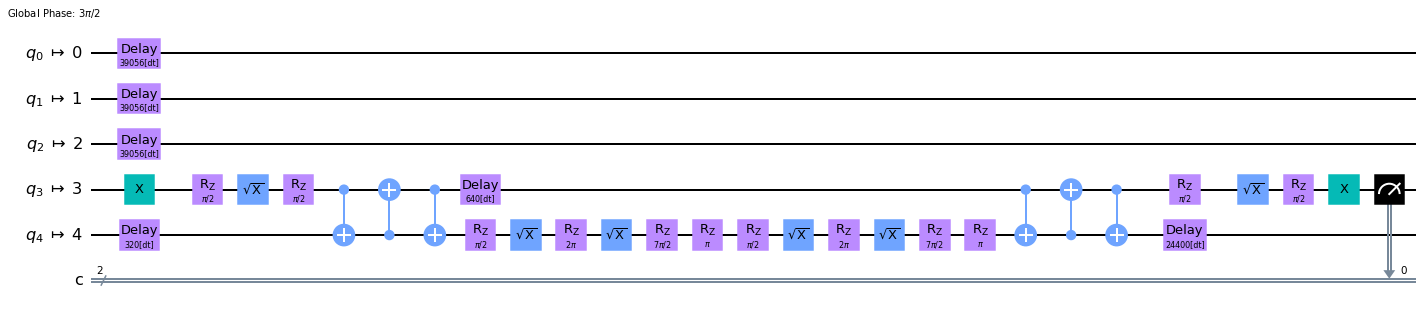

In [10]:
num_blocks=1
get_protocol_transpiled_circuit_YZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot13, tau_cnot31,
                                    state="-", DD_wait=True)[0].draw("mpl", fold=-1)

**Circuit building settings.**

In [11]:
max_time   = 15 # In us.
num_steps  = 15
wait_times = np.linspace(0, max_time, num_steps)  # In us.
#print(wait_times)

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case
#print(num_blocks_array_XY, num_blocks_array_XZ, num_blocks_array_YZ)
#print(num_blocks_array, num_steps*4*2, num_steps==len(num_blocks_array))
#print(4*num_blocks_array)

shots = 2**13 # 8192
#print(shots)

states = [0, 1, "+", "-"]
repetitions = 10

reshape_dims = (len(states), repetitions, 4, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))

## Build the circuits

In [ ]:
all_wait_times = []
all_counts = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |0>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |1>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |+>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |->]
"""

for i, state in enumerate(states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []

    print("State:", state)
    print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=state, DD_wait=True)
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
        
    print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit_XZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=state, DD_wait=True)
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
        
    print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the XZXZ circuits.
        print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit_YZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=state, DD_wait=True)
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration, tau_cnot34, tau_cnot43,
                                    state=state, DD_wait=False)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    #print("Number of circuits:", len(circuits_array_flattened))
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()
        
    print("Done!")
print("Finished!")

### Plot a circuit schedule to look for errors.

In [13]:
# Instruction durations for the schedule plot

durations = InstructionDurations(
    [("h", 1, H_duration), 
     ("x", 0, X_duration), 
     ("x", 1, X_duration), 
     ("x", 2, X_duration), 
     ("x", 3, X_duration), 
     ("x", 4, X_duration), 
     ("z", 0, Z_duration), 
     ("z", 1, Z_duration), 
     ("z", 2, Z_duration), 
     ("z", 3, Z_duration), 
     ("z", 4, Z_duration),
     ("id", 0, I_duration),
     ("id", 1, I_duration),
     ("id", 2, I_duration),
     ("id", 3, I_duration),
     ("id", 4, I_duration),
     ("cx", [0, 1], CNOT_durations["[0, 1]"]), 
     ("cx", [1, 0], CNOT_durations["[1, 0]"]),
     ("cx", [1, 3], CNOT_durations["[1, 3]"]),
     ("cx", [3, 4], CNOT_durations["[3, 4]"]),
     ("cx", [4, 3], CNOT_durations["[4, 3]"]),
     ("reset", None, Reset_duration),
     ("measure", None, Measurement_duration)]
)

pm = PassManager([ALAPSchedule(durations)])

In [14]:
# Style for the schedule plot

# https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html
# https://qiskit.org/documentation/stubs/qiskit.visualization.timeline_drawer.html
# https://github.com/Qiskit/qiskit-terra/pull/5063/files/5fa5898bad0a53da23c0daa61f2d99c7e822de1b#diff-4ad47bcead055d747c1ef626ff0baece4907ef6e8ee6a227c9df53459ca9ea86

my_style = {
    "formatter.latex_symbol.frame_change" : r"\,",
    'formatter.general.fig_width': 20,
    #"formatter.unicode_symbol.frame_change" : "",
    #"formatter.layer.frame_change" : 0,
    #"formatter.text_size.frame_change":0,
    #"formatter.alpha.gates":0,
    "formatter.text_size.gate_name": 14,
    "formatter.time_bucket.edge_dt": 100,
    "formatter.latex_symbol.gates":
        {
        'rz': r'\,',
        'x': r'\,',
        'sx': r'\,',
        'id': r'\,',
        'reset': r'|0\rangle',
        'measure': r'{\rm Measure}'
        },
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C',
        'sx': '#DC143C',
        'reset': '#a0a0a0',
        'measure': '#a0a0a0' #'#808080',
        #'delay': '#1E90FF'
        }
}

style = IQXStandard(**my_style)

C:\Users\usuario\AppData\Local\Temp\ipykernel_14992\213054133.py:1: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][0][2]
C:\Users\usuario\AppData\Local\Temp\ipykernel_14992\213054133.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample_circuit = np.asarray(all_transpiled_circuits).re

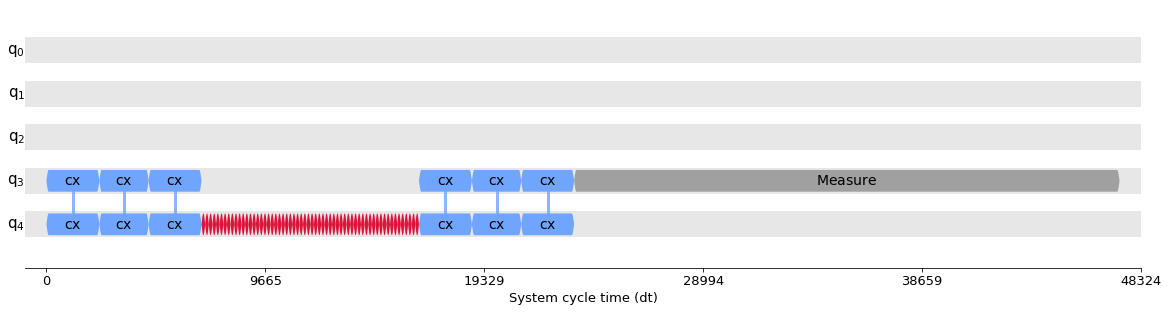

In [15]:
sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][0][2] # [state][repetition][sequence type][num_blocks index]
timeline_drawer(sample_circuit, style=style)#, show_delays=True)

## Send the job set to IBM

In [43]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='XYXY-XZXZ-YZYZ-IIII-SingleQubitStates-errorBars-8192shots-15us-15steps-10reps-q3q4', shots=shots)
#job_monitor(job_set)

**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

**For checking the job status, etc.**

In [ ]:
job_set.statuses()
#job_set.cancel ()
#job_set.error_messages()

**For retrieving past job sets.**

In [17]:
job_manager = IBMQJobManager()
job_set = job_manager.retrieve_job_set("put-the-job_set-id-here", provider)

## Get the job results

In [ ]:
results = job_set.results()

In [19]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

**For measurement error mitigation:**

In [28]:
all_counts_array_mit = np.asarray([meas_filter.apply(all_counts_array[i]) for i in range(len(all_counts_array))])

In [29]:
all_counts_array = all_counts_array_mit

## Get the counts

Get the raw counts

In [30]:
counts0_0_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[0][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[0][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[0][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_0_IIII = np.array([[all_counts_array.reshape(reshape_dims)[0][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts0_1_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[1][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[1][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[1][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_1_IIII = np.array([[all_counts_array.reshape(reshape_dims)[1][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts0_p_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[2][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_p_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[2][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_p_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[2][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_p_IIII = np.array([[all_counts_array.reshape(reshape_dims)[2][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts0_m_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[3][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_m_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[3][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_m_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[3][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts0_m_IIII = np.array([[all_counts_array.reshape(reshape_dims)[3][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

raw_counts00 = [[counts0_0_XYXY, counts0_0_XZXZ, counts0_0_YZYZ, counts0_0_IIII],
                [counts0_1_XYXY, counts0_1_XZXZ, counts0_1_YZYZ, counts0_1_IIII],
                [counts0_p_XYXY, counts0_p_XZXZ, counts0_p_YZYZ, counts0_p_IIII],
                [counts0_m_XYXY, counts0_m_XZXZ, counts0_m_YZYZ, counts0_m_IIII]]

Get the average of the repetitions

In [31]:
avg_counts0_0_XYXY = np.round(np.average(counts0_0_XYXY, axis=0)).astype(int)
avg_counts0_0_XZXZ = np.round(np.average(counts0_0_XZXZ, axis=0)).astype(int)
avg_counts0_0_YZYZ = np.round(np.average(counts0_0_YZYZ, axis=0)).astype(int)
avg_counts0_0_IIII = np.round(np.average(counts0_0_IIII, axis=0)).astype(int)

avg_counts0_1_XYXY = np.round(np.average(counts0_1_XYXY, axis=0)).astype(int)
avg_counts0_1_XZXZ = np.round(np.average(counts0_1_XZXZ, axis=0)).astype(int)
avg_counts0_1_YZYZ = np.round(np.average(counts0_1_YZYZ, axis=0)).astype(int)
avg_counts0_1_IIII = np.round(np.average(counts0_1_IIII, axis=0)).astype(int)

avg_counts0_p_XYXY = np.round(np.average(counts0_p_XYXY, axis=0)).astype(int)
avg_counts0_p_XZXZ = np.round(np.average(counts0_p_XZXZ, axis=0)).astype(int)
avg_counts0_p_YZYZ = np.round(np.average(counts0_p_YZYZ, axis=0)).astype(int)
avg_counts0_p_IIII = np.round(np.average(counts0_p_IIII, axis=0)).astype(int)

avg_counts0_m_XYXY = np.round(np.average(counts0_m_XYXY, axis=0)).astype(int)
avg_counts0_m_XZXZ = np.round(np.average(counts0_m_XZXZ, axis=0)).astype(int)
avg_counts0_m_YZYZ = np.round(np.average(counts0_m_YZYZ, axis=0)).astype(int)
avg_counts0_m_IIII = np.round(np.average(counts0_m_IIII, axis=0)).astype(int)

avg_counts0 = [[avg_counts0_0_XYXY, avg_counts0_0_XZXZ, avg_counts0_0_YZYZ, avg_counts0_0_IIII],
                [avg_counts0_1_XYXY, avg_counts0_1_XZXZ, avg_counts0_1_YZYZ, avg_counts0_1_IIII],
                [avg_counts0_p_XYXY, avg_counts0_p_XZXZ, avg_counts0_p_YZYZ, avg_counts0_p_IIII],
                [avg_counts0_m_XYXY, avg_counts0_m_XZXZ, avg_counts0_m_YZYZ, avg_counts0_m_IIII]]

Get the maximum count values of the repetitions

In [32]:
max_counts0_0_XYXY = np.max(counts0_0_XYXY, axis=0)
max_counts0_0_XZXZ = np.max(counts0_0_XZXZ, axis=0)
max_counts0_0_YZYZ = np.max(counts0_0_YZYZ, axis=0)
max_counts0_0_IIII = np.max(counts0_0_IIII, axis=0)

max_counts0_1_XYXY = np.max(counts0_1_XYXY, axis=0)
max_counts0_1_XZXZ = np.max(counts0_1_XZXZ, axis=0)
max_counts0_1_YZYZ = np.max(counts0_1_YZYZ, axis=0)
max_counts0_1_IIII = np.max(counts0_1_IIII, axis=0)

max_counts0_p_XYXY = np.max(counts0_p_XYXY, axis=0)
max_counts0_p_XZXZ = np.max(counts0_p_XZXZ, axis=0)
max_counts0_p_YZYZ = np.max(counts0_p_YZYZ, axis=0)
max_counts0_p_IIII = np.max(counts0_p_IIII, axis=0)

max_counts0_m_XYXY = np.max(counts0_m_XYXY, axis=0)
max_counts0_m_XZXZ = np.max(counts0_m_XZXZ, axis=0)
max_counts0_m_YZYZ = np.max(counts0_m_YZYZ, axis=0)
max_counts0_m_IIII = np.max(counts0_m_IIII, axis=0)

max_counts0 = [[max_counts0_0_XYXY, max_counts0_0_XZXZ, max_counts0_0_YZYZ, max_counts0_0_IIII],
                [max_counts0_1_XYXY, max_counts0_1_XZXZ, max_counts0_1_YZYZ, max_counts0_1_IIII],
                [max_counts0_p_XYXY, max_counts0_p_XZXZ, max_counts0_p_YZYZ, max_counts0_p_IIII],
                [max_counts0_m_XYXY, max_counts0_m_XZXZ, max_counts0_m_YZYZ, max_counts0_m_IIII]]

Get the minimum count values of the repetitions

In [33]:
min_counts0_0_XYXY = np.max(counts0_0_XYXY, axis=0)
min_counts0_0_XZXZ = np.max(counts0_0_XZXZ, axis=0)
min_counts0_0_YZYZ = np.max(counts0_0_YZYZ, axis=0)
min_counts0_0_IIII = np.max(counts0_0_IIII, axis=0)

min_counts0_1_XYXY = np.min(counts0_1_XYXY, axis=0)
min_counts0_1_XZXZ = np.min(counts0_1_XZXZ, axis=0)
min_counts0_1_YZYZ = np.min(counts0_1_YZYZ, axis=0)
min_counts0_1_IIII = np.min(counts0_1_IIII, axis=0)

min_counts0_p_XYXY = np.min(counts0_p_XYXY, axis=0)
min_counts0_p_XZXZ = np.min(counts0_p_XZXZ, axis=0)
min_counts0_p_YZYZ = np.min(counts0_p_YZYZ, axis=0)
min_counts0_p_IIII = np.min(counts0_p_IIII, axis=0)

min_counts0_m_XYXY = np.min(counts0_m_XYXY, axis=0)
min_counts0_m_XZXZ = np.min(counts0_m_XZXZ, axis=0)
min_counts0_m_YZYZ = np.min(counts0_m_YZYZ, axis=0)
min_counts0_m_IIII = np.min(counts0_m_IIII, axis=0)

min_counts0 = [[min_counts0_0_XYXY, min_counts0_0_XZXZ, min_counts0_0_YZYZ, min_counts0_0_IIII],
                [min_counts0_1_XYXY, min_counts0_1_XZXZ, min_counts0_1_YZYZ, min_counts0_1_IIII],
                [min_counts0_p_XYXY, min_counts0_p_XZXZ, min_counts0_p_YZYZ, min_counts0_p_IIII],
                [min_counts0_m_XYXY, min_counts0_m_XZXZ, min_counts0_m_YZYZ, min_counts0_m_IIII]]

## Plot the results

**Plot the raw data without mitigation or shifting:**

0 0 <Parameter 'T', value=70.5372982479059 +/- 1.81, bounds=[0:inf]> <Parameter 'C', value=-0.05805249716785401 +/- 0.00271, bounds=[-inf:inf]>
0 1 <Parameter 'T', value=41.54562802806303 +/- 0.983, bounds=[0:inf]> <Parameter 'C', value=-0.052053521885967326 +/- 0.0038, bounds=[-inf:inf]>
0 2 <Parameter 'T', value=38.035952003533794 +/- 1.02, bounds=[0:inf]> <Parameter 'C', value=-0.04790500590770519 +/- 0.00456, bounds=[-inf:inf]>
0 3 <Parameter 'T', value=4824570195.814678 +/- 1.31e+15, bounds=[0:inf]> <Parameter 'C', value=-0.05069173120858393 +/- 0.000736, bounds=[-inf:inf]>
1 0 <Parameter 'T', value=73.21339304890164 +/- 2.01, bounds=[0:inf]> <Parameter 'C', value=-0.06389083327271318 +/- 0.00281, bounds=[-inf:inf]>
1 1 <Parameter 'T', value=38.16688440819986 +/- 0.818, bounds=[0:inf]> <Parameter 'C', value=-0.05147502808520302 +/- 0.00366, bounds=[-inf:inf]>
1 2 <Parameter 'T', value=31.959155771184264 +/- 0.651, bounds=[0:inf]> <Parameter 'C', value=-0.04326933984522041 +/- 0.00

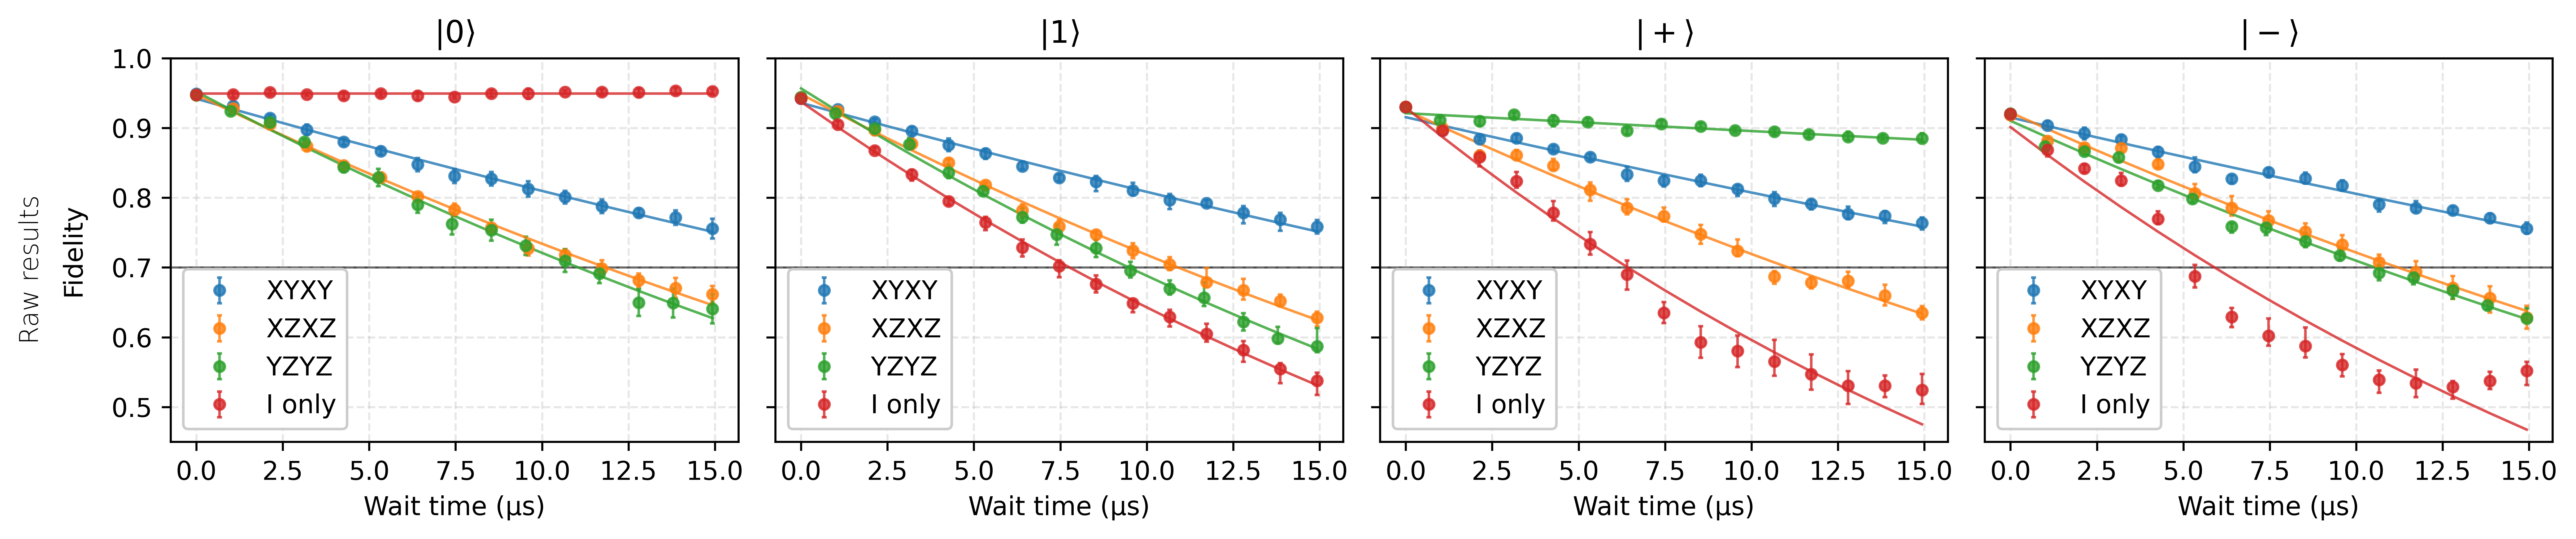

In [65]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

bell_labels = ["$|0\\rangle$", "$|1\\rangle$", "$|+\\rangle$", "$|-\\rangle$"]
wait_times = np.linspace(0, 15, 15)

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(14,3), constrained_layout=False, dpi=600)

axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Error bar line width
a = 0.8 # Alpha
cs = 1 # Error bar cap size

Tvals = [[],[],[],[]]
Cvals = [[],[],[],[]]

for i in range(4): # For each state
        
    axs[i].set_title(bell_labels[i])
    axs[i].set_xlabel("Wait time (μs)")
    axs[i].set_ylim((0.45,1))

    # Get the wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # Get the fidelities
    fidelity_XYXY = avg_counts0[i][0]/shots
    fidelity_XZXZ = avg_counts0[i][1]/shots
    fidelity_YZYZ = avg_counts0[i][2]/shots
    fidelity_IIII = avg_counts0[i][3]/shots
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts0[i][0]/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts0[i][0]/shots)
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts0[i][1]/shots)
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts0[i][1]/shots)
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts0[i][2]/shots)
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts0[i][2]/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts0[i][3]/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts0[i][3]/shots)
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts0[i][k]/shots
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=100, min=0)
        exp_model.set_param_hint('C', value=0.5)
        fit_result = exp_model.fit(state_data, x=state_times)
        print(i, k, fit_result.params["T"], fit_result.params["C"])

        # Store for printing in a nice format later
        Tvals[i].append([str(np.round(fit_result.params["T"].value,3)), str(np.round(fit_result.params["T"].stderr,3))])
        Cvals[i].append([str(np.round(fit_result.params["C"].value,3)), str(np.round(fit_result.params["C"].stderr,3))])
        
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
     
    axs[i].axhline(0.7, lw=0.8, ls="solid", c="k", alpha=0.7, zorder=0)
    axs[i].legend(framealpha=1, loc="lower left")#, handletextpad=0)
    axs[i].grid(linestyle="--", alpha=0.3, zorder=0.1)

fig.supylabel("Raw results", x=0.015, fontweight="light", fontsize=10)
plt.tight_layout()
plt.show()
#plt.savefig(r"lima_4sequences_8192Shots_errorbars_10Reps_15us_15steps_singleQubitq3q4_13082022_fit.pdf")  

Now we print the fit parameters a bit more nicely

In [66]:
for i, seq in enumerate(["XYXY", "XZXZ", "YZYZ", "I only"]):
    print(seq)
    print(np.asarray(Tvals)[:,i,0])
    print(np.asarray(Tvals)[:,i,1])
    print()

XYXY
['70.537' '73.213' '87.466' '86.276']
['1.807' '2.005' '3.537' '3.571']

XZXZ
['41.546' '38.167' '43.246' '44.598']
['0.983' '0.818' '1.498' '1.433']

YZYZ
['38.036' '31.959' '385.606' '44.642']
['1.016' '0.651' '41.965' '1.36']

I only
['4824570195.815' '28.627' '24.678' '26.256']
['1305979799720309.5' '0.37' '1.555' '2.807']



In [25]:
# For LaTeX
for i in range(4): # for each sequence
    t1, t2, t3, t4 = np.asarray(Tvals)[:,i]
    c1, c2, c3, c4 = np.asarray(Cvals)[:,i]
    print(t1, "&", t2, "&", t3, "&", t4, "\\\\")
    print(c1, "&", c2, "&", c3, "&", c4, "\\\\")

$70.537 \pm 1.807$ & $73.213 \pm 2.005$ & $87.466 \pm 3.537$ & $86.276 \pm 3.571$ \\
$-0.0581 \pm 0.0027$ & $-0.0639 \pm 0.0028$ & $-0.0845 \pm 0.0036$ & $-0.0849 \pm 0.0037$ \\
$41.546 \pm 0.983$ & $38.167 \pm 0.818$ & $43.246 \pm 1.498$ & $44.598 \pm 1.433$ \\
$-0.0521 \pm 0.0038$ & $-0.0515 \pm 0.0037$ & $-0.0743 \pm 0.0054$ & $-0.0777 \pm 0.0049$ \\
$38.036 \pm 1.016$ & $31.959 \pm 0.651$ & $385.606 \pm 41.965$ & $44.642 \pm 1.36$ \\
$-0.0479 \pm 0.0046$ & $-0.0433 \pm 0.0039$ & $-0.0788 \pm 0.0024$ & $-0.0897 \pm 0.0046$ \\
$4824570195.815 \pm 1305979799720309.5$ & $28.627 \pm 0.37$ & $24.678 \pm 1.555$ & $26.256 \pm 2.807$ \\
$-0.0507 \pm 0.0007$ & $-0.0624 \pm 0.0027$ & $-0.0708 \pm 0.0142$ & $-0.0987 \pm 0.0233$ \\


**With measurement error mitigation and shifting**

Note: Run the cells above related to the error mitigation of the counts.

0 0 <Parameter 'T', value=70.53729804109489 +/- 1.81, bounds=[0:inf]> <Parameter 'C', value=-0.0055622625243707015 +/- 0.00271, bounds=[-inf:inf]>
0 1 <Parameter 'T', value=41.5456279744364 +/- 0.983, bounds=[0:inf]> <Parameter 'C', value=0.0004367126706402657 +/- 0.0038, bounds=[-inf:inf]>
0 2 <Parameter 'T', value=38.03595247832878 +/- 1.02, bounds=[0:inf]> <Parameter 'C', value=0.004585226047842988 +/- 0.00456, bounds=[-inf:inf]>
0 3 <Parameter 'T', value=1820614643.4053397 +/- 1.89e+14, bounds=[0:inf]> <Parameter 'C', value=0.0017985042735399618 +/- 0.000801, bounds=[-inf:inf]>
1 0 <Parameter 'T', value=73.21339294266774 +/- 2.01, bounds=[0:inf]> <Parameter 'C', value=-0.006273645673521542 +/- 0.00281, bounds=[-inf:inf]>
1 1 <Parameter 'T', value=38.166884364546924 +/- 0.818, bounds=[0:inf]> <Parameter 'C', value=0.006142159586372564 +/- 0.00366, bounds=[-inf:inf]>
1 2 <Parameter 'T', value=31.959155179157484 +/- 0.651, bounds=[0:inf]> <Parameter 'C', value=0.014347851689646791 +/-

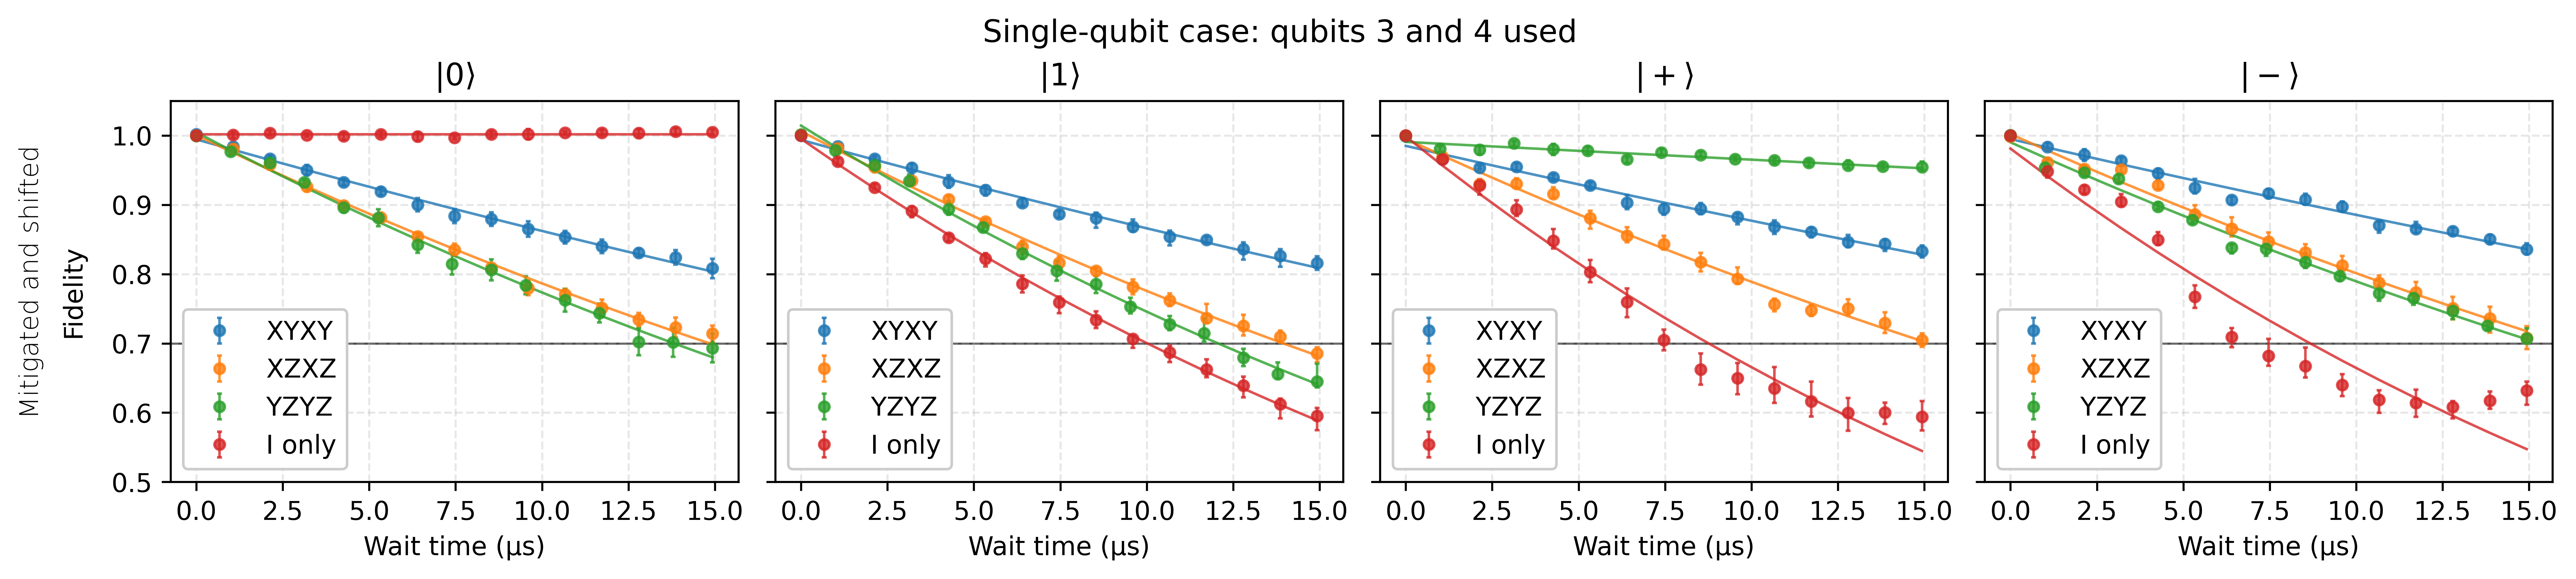

In [59]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

bell_labels = ["$|0\\rangle$", "$|1\\rangle$", "$|+\\rangle$", "$|-\\rangle$"]
wait_times = np.linspace(0, 15, 15)
fidAfter2Swaps = []
corrections = []

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(14,3.3), constrained_layout=False, dpi=600)

axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Error bar line width
a = 0.8 # Alpha
cs = 1 # Error bar cap size

Tvals = [[],[],[],[]]
Cvals = [[],[],[],[]]

for i in range(4): # For each state
        
    axs[i].set_title(bell_labels[i])
    axs[i].set_xlabel("Wait time (μs)")
    axs[i].set_ylim((0.5,1.05))

    # Get wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # For shifting the plots
    fidAfter2Swaps.append(avg_counts0[i][3][0]/shots)
    corrections.append(1-avg_counts0[i][3][0]/shots)
    
    # Get the fidelities
    fidelity_XYXY = avg_counts0[i][0]/shots + corrections[i]
    fidelity_XZXZ = avg_counts0[i][1]/shots + corrections[i]
    fidelity_YZYZ = avg_counts0[i][2]/shots + corrections[i]
    fidelity_IIII = avg_counts0[i][3]/shots + corrections[i]
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts0[i][0]/shots-corrections[i])
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts0[i][0]/shots-corrections[i])
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts0[i][1]/shots-corrections[i])
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts0[i][1]/shots-corrections[i])
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts0[i][2]/shots-corrections[i])
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts0[i][2]/shots-corrections[i])
    min_err_IIII = np.abs(fidelity_IIII-min_counts0[i][3]/shots-corrections[i])
    max_err_IIII = np.abs(fidelity_IIII-max_counts0[i][3]/shots-corrections[i])
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts0[i][k]/shots + corrections[i]
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=100, min=0)
        exp_model.set_param_hint('C', value=0.5)
        fit_result = exp_model.fit(state_data, x=state_times)
        print(i, k, fit_result.params["T"], fit_result.params["C"])

        # Store for printing in a nice format later
        Tvals[i].append([str(np.round(fit_result.params["T"].value,3)), str(np.round(fit_result.params["T"].stderr,3))])
        Cvals[i].append([str(np.round(fit_result.params["C"].value,3)), str(np.round(fit_result.params["C"].stderr,3))])
        
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
     
    axs[i].axhline(0.7, lw=0.8, ls="solid", c="k", alpha=0.7, zorder=0)
    axs[i].legend(framealpha=1, loc="lower left")
    axs[i].grid(linestyle="--", alpha=0.3, zorder=0.1)

print(corrections)
fig.suptitle("Single-qubit case: qubits 3 and 4 used", y=0.93)
fig.supylabel("Mitigated and shifted", x=0.015, fontweight="light", fontsize=10)
plt.tight_layout()
plt.show()
#plt.savefig(r"lima_4sequences_8192Shots_errorbars_10Reps_15us_15steps_singleQubitq3q4_13082022_fit_mitigated.pdf")  

Now we print the fit parameters a bit more nicely

In [58]:
for i, seq in enumerate(["XYXY", "XZXZ", "YZYZ", "I only"]):
    print(seq)
    print(np.asarray(Tvals)[:,i,0])
    print(np.asarray(Tvals)[:,i,1])
    print()

XYXY
['70.537' '73.213' '87.466' '86.276']
['1.807' '2.005' '3.537' '3.571']

XZXZ
['41.546' '38.167' '43.246' '44.598']
['0.983' '0.818' '1.498' '1.433']

YZYZ
['38.036' '31.959' '385.606' '44.642']
['1.016' '0.651' '41.965' '1.36']

I only
['1820614643.405' '28.627' '24.678' '26.256']
['189420538259099.62' '0.37' '1.555' '2.807']



In [35]:
# For LaTeX
for i in range(4): # for each sequence
    t1, t2, t3, t4 = np.asarray(Tvals)[:,i]
    c1, c2, c3, c4 = np.asarray(Cvals)[:,i]
    print(t1, "&", t2, "&", t3, "&", t4, "\\\\")
    print(c1, "&", c2, "&", c3, "&", c4, "\\\\")

$65.554 \pm 1.652$ & $68.026 \pm 1.844$ & $81.382 \pm 3.284$ & $80.266 \pm 3.314$ \\
$-0.0058 \pm 0.0028$ & $-0.0064 \pm 0.003$ & $-0.0158 \pm 0.0038$ & $-0.0052 \pm 0.0039$ \\
$38.364 \pm 0.891$ & $35.202 \pm 0.751$ & $39.977 \pm 1.401$ & $41.257 \pm 1.368$ \\
$0.0011 \pm 0.004$ & $0.0075 \pm 0.0039$ & $-0.0044 \pm 0.0058$ & $0.0028 \pm 0.0054$ \\
$35.083 \pm 0.945$ & $29.404 \pm 0.638$ & $361.283 \pm 39.324$ & $41.278 \pm 1.264$ \\
$0.0056 \pm 0.0049$ & $0.0164 \pm 0.0044$ & $-0.0099 \pm 0.0026$ & $-0.0098 \pm 0.0049$ \\
$3404944492.096 \pm 415480995686650.9$ & $26.24 \pm 0.298$ & $22.462 \pm 1.412$ & $23.869 \pm 2.568$ \\
$0.0019 \pm 0.0008$ & $-0.0035 \pm 0.0025$ & $0.0013 \pm 0.0149$ & $-0.0171 \pm 0.0248$ \\
